# `rioxarray` 

`rioxarray`:
- is a python extension for `xarray` to manipulate `xarray.DataArray`'s as rasters
- means *raster input/output + xarray*

## Data
Raster files from the US National Agriculture Imagery Program (NAIP)

- high-resolution aerial images from 2020 with four spectral bands: Red, Green, Blue, and Near-infrared (NIR)
- data is pre-processed into two rasters (RGB and NIR)

## Import.tif

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rioxarray as rioxr

import geopandas as gpd
from shapely.geometry import Polygon

In [3]:
# load NIR tif file
nir_fp = os.path.join(os.getcwd(),'data','nir.tif')
nir = rioxr.open_rasterio(nir_fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)>
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## `xr.DataArray` exploration

Let's verify we loaded an `xarray.DataArray`

In [4]:
type(nir)

xarray.core.dataarray.DataArray

In [5]:
# print shape and data type
print('shape: ', nir.shape)
print('data type: ', nir.dtype, '\n')

shape:  (1, 3208, 2419)
data type:  uint8 



In [6]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

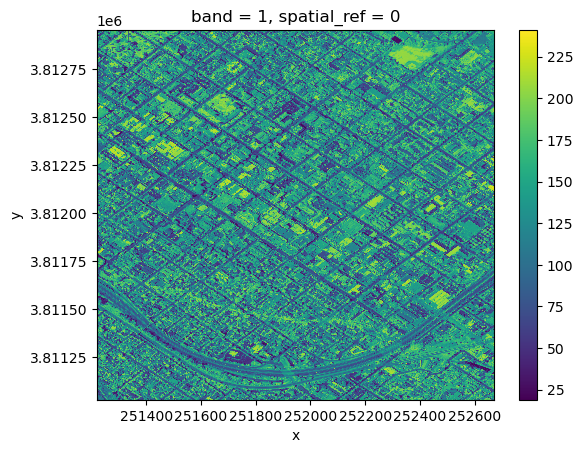

In [7]:
nir.plot()

## `xr.accessor`

An **accessor** in Python let’s us access a different set of properties of an object. In our case, we use the `.rio` accessor for `xarray.DataArrays` to access its raster properties. For example, its number of bands, height, width, spatial bounding box, and CRS:

In [8]:
# check geospatial attributes
print('# bands: ', nir.rio.count)
print('height: ', nir.rio.height)
print('width: ', nir.rio.width, '\n')

print('spatial bounding box: ')
print(nir.rio.bounds(), '\n')

print('CRS: ', nir.rio.crs)

# bands:  1
height:  3208
width:  2419 

spatial bounding box: 
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

CRS:  EPSG:26911


## Multi-Band Raster


In [9]:
# open RGB raster
rgb_fp = os.path.join(os.getcwd(),'data','rgb.tif')
rgb = rioxr.open_rasterio(rgb_fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)>
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Notice this raster has three bands, instead of one. This makes sense because we know these bands correspond tothe Red, Green and Blue bands of the image. We can also check this information by looking directly at the attributes:

In [10]:
print('rgb shape: ', rgb.shape)
print('rgb # bands: ', rgb.rio.count)

rgb shape:  (3, 3208, 2419)
rgb # bands:  3


In [11]:
# check geospatial attributes
print('shape: ', rgb.shape)
print('data type: ', rgb.dtype)
print('# bands: ', rgb.rio.count)
print('CRS: ', rgb.rio.crs)

# check if the CRSs of the rasters match
print( rgb.rio.crs == nir.rio.crs)

shape:  (3, 3208, 2419)
data type:  uint8
# bands:  3
CRS:  EPSG:26911
True


Finally, let’s plot this raster. Since it has three bands, we can plot it as an image using the `.plot.imshow()` method, which will interpret the three bands of the object as RGB.

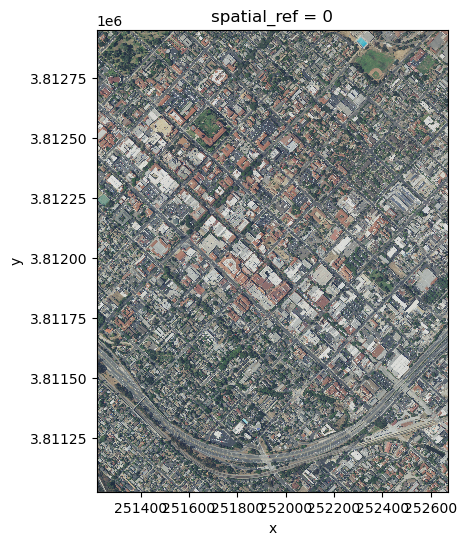

In [12]:
# parameters for plotting rasters
size = 6 # height in in of plot height
aspect = rgb.rio.width / rgb.rio.height # ratio of widht/height

# plot three bands as RGB image
rgb.plot.imshow(size=size, aspect=aspect)

## Box for Clipping

Our area of interest (aoi) for this lesson is a smaller region that includes only a few blocks around the NCEAS building. An easy way to obtain coordinates for such a region:


- go to https://geojson.io/ website,
- zoom in until you find the NCEAS building in Santa Barbara, it might help to change to ‘Satellite Streets’ view on the bottom left corner,
- click on the rectangle icon on the right-side toolbar and draw a small region around the NCEAS buildng, the geoJSON code representing this area will appear in the code box,
- one option is two copy-paste this geoJSON into an empty text file and save such file with the .json extension, we could then read it in using geopandas
- instead, we will create our region of index by just copy-pasting the list of points and storing it as a variable:

In [13]:
# vertices of our aoi box
points = [[-119.70608227128903, 34.426300194372274],
          [-119.70608227128903, 34.42041139020533],
          [-119.6967885126002, 34.42041139020533],
          [-119.6967885126002, 34.426300194372274],
          [-119.70608227128903, 34.426300194372274]]

In [14]:
# create geodataframe with aoi 
aoi = gpd.GeoDataFrame(geometry=[Polygon(points)],
                           crs='epsg:4326')
aoi

,geometry
0,"POLYGON ((-119.70608 34.42630, -119.70608 34.4..."


Let’s break this down a bit:

first, we use the shapely’s `Polygon()` function to create a polygon from our points list.
in `[Polygon(points)]` we put this polygon inside a list so we can form the geometry column of our new `gpd.GeoDataFrame`
we know all the `geoJSON` files have CRS equal to EPSG:4326/WGS 84, so we set the the CRS of our new `gpd.GeoDataFrame` to this.

## Clip Raster
Remember: if two geospatial sets will interact they need to be in the same CRS.
In our case, the aoi `gpd.GeoDataFrame` does not have the same CRS as the rasters:

In [ ]:
# check CRss
print('aoi CRS: ', aoi.crs)
print('nir CRS: ', nir.rio.crs)
print('rgb CRS: ', rgb.rio.crs)

In [15]:
# reproject aoi to rgb crs
aoi = aoi.to_crs(rgb.rio.crs)
print('matched crs?',  aoi.crs == rgb.rio.crs)
aoi.crs

matched crs? True


<Bound CRS: PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM ...>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from NAD83 to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: NAD83 / UTM zone 11N

<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x', ylabel='y'>

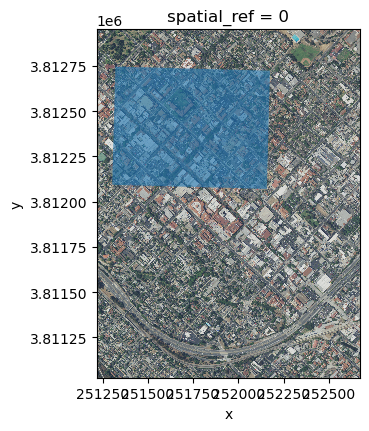

In [16]:
# plot aoi outline and RGB raster together
fig, ax = plt.subplots()
fig.set_size_inches((size, size*aspect)) # reuse size and aspect
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)

In [17]:
# clip rasters to aoi
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

Notice a few things: 
- we had to use the `.rio` accessor to access the `clip_box()` method
- similarly to the `shapely.box()` function we’ve used previously, `.rio.clip_box()` usual parameters are minx, miny, maxx, maxy.
- We are using the * asterisk as an unpacking operator to get these from the list `aoi.total_bounds`.

In [ ]:
# check shape updates
print('original shape: ', rgb.shape)
print('reduced shape: ', rgb_small.shape)

# plot with correct sizes
size = 4
aspect = rgb_small.rio.width/ rgb_small.rio.height
rgb_small.plot.imshow(size=size, aspect=aspect)

original shape:  (1, 3208, 2419)
reduced shape:  (1, 1128, 1454)


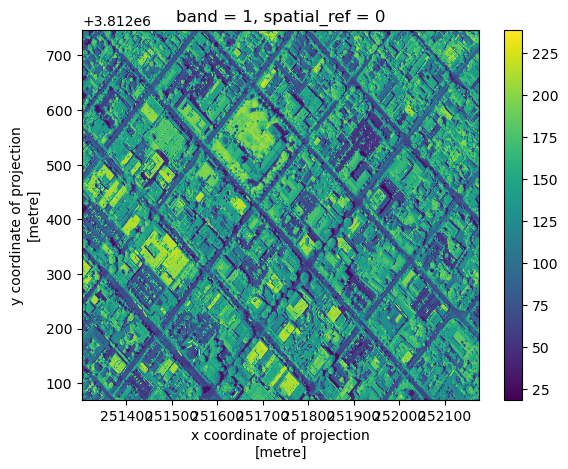

In [18]:
# check shape updates
print('original shape: ', nir.shape)
print('reduced shape: ', nir_small.shape)

nir_small.plot()

## Compute NDVI

We often want to combine values of and perform calculations on rasters to create a new output raster. In our case, we are interested in computing the Normalized Difference Vegetation Index (NDVI) over our area of interest. The NDVI is an index commonly used to check if an area has live green vegetation or not.

According to the Earth Observing System > The results of the NDVI calculation range from -1 to 1. Negative values correspond to areas with water surfaces, manmade structures, rocks, clouds, snow; bare soil usually falls within 0.1-0.2 range; and plants will always have positive values between 0.2 and 1. Healthy, dense vegetation canopy should be above 0.5, and sparse vegetation will most likely fall within 0.2 to 0.5.

The NDVI is calculated using the NIR and red bands. The formula is:

NDVI = (NIR - Red)/(NIR + Red)

 

First, we need to select the red band:

In [22]:
# select the red band
red = rgb_small.sel(band=1)
red

<xarray.DataArray (y: 1128, x: 1454)>
[1640112 values with dtype=uint8]
Coordinates:
    band         int64 1
  * x            (x) float64 2.513e+05 2.513e+05 ... 2.522e+05 2.522e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [23]:
# udpate the data type of our rasters
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')
print('RED: original dtype:', rgb_small.dtype, '.... converted dtype:', red16.dtype)
print('NIR: original dtype:', nir.dtype, '.... converted dtype:', nir16.dtype)

RED: original dtype: uint8 .... converted dtype: int16
NIR: original dtype: uint8 .... converted dtype: int16


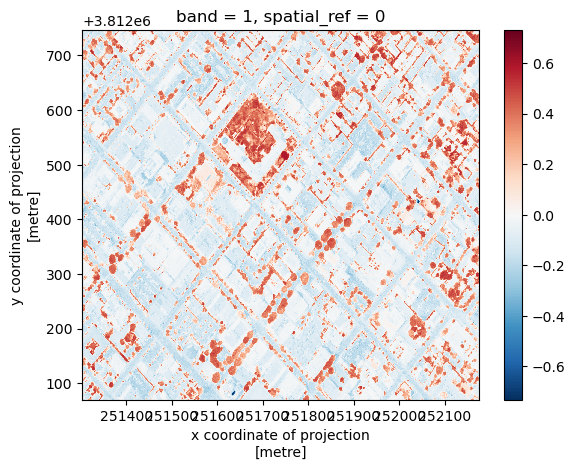

In [21]:
# calculate and plot NDVI
ndvi = (nir16 - red16)/(nir16+red16)
ndvi.plot()